In [1]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True) 

# Other possible environment configurations are:

# env = gym.make('Blackjack-v1', natural=True, sab=False)
# Whether to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

# env = gym.make('Blackjack-v1', natural=False, sab=False)
# Whether to follow the exact rules outlined in the book by Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.

In [2]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# observation = (16, 9, False) Player current sum, value of dealers face-up cards, bool if player holds usable ace (counts as 11 without busting)

In [3]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float, # how much the agent should update its Q values based on new experiences
        initial_epsilon: float, # starting exploration rate
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95, # defines how much to prefer future rewards to imideate rewards
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:    # what action to do based on curretn observation
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()    # return random sample toe explore environment

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [4]:
# hyperparameters
learning_rate = 0.001
n_episodes = 100_0000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [5]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)): #tqdm visual indicator of training progress
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [01:12<00:00, 13888.50it/s]


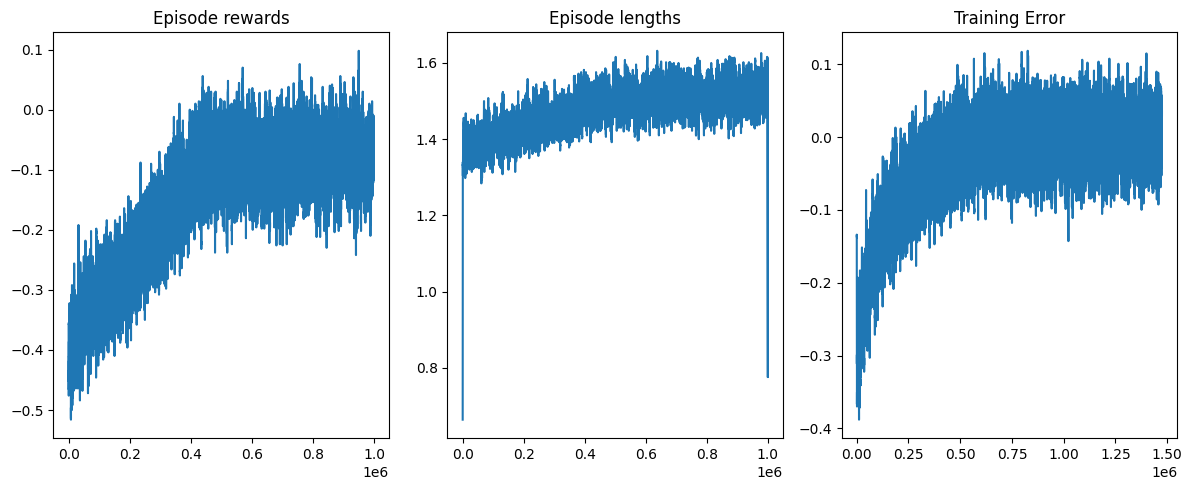

In [6]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

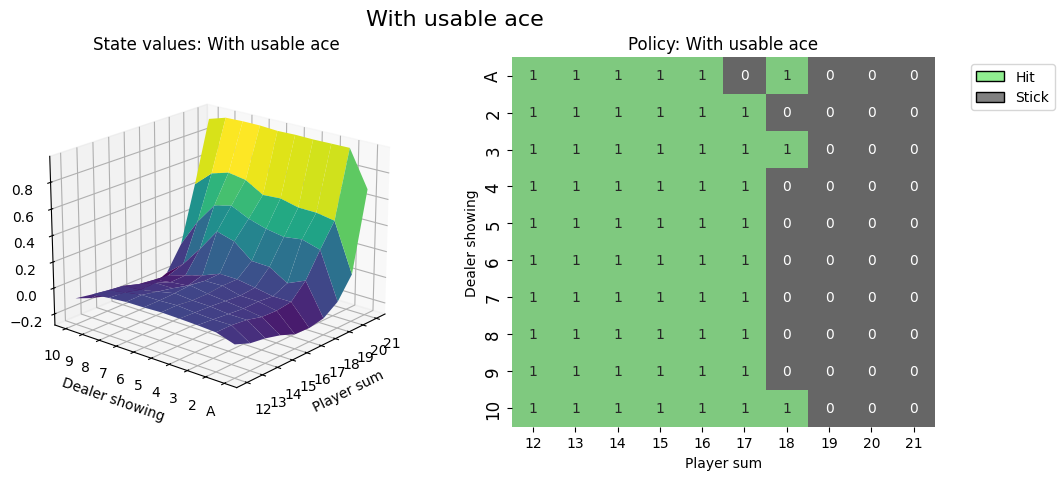

In [7]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()


100%|██████████| 1000/1000 [00:00<00:00, 56459.29it/s]

   Action 0  Action 1  Action 2  Action 3  Action 4  Action 5
4  0.630542  0.000000   0.00000  0.634926       0.0       1.0
3  0.000000  0.823063   0.53469  0.000000       1.0       0.0
0  0.000000  0.000000   0.00000  0.000000       1.0       0.0
5  0.000000  0.000000   0.00000  0.000000       0.0       0.0
2  0.000000  0.000000   0.00000  1.000000       0.0       0.0
1  0.000000  0.000000   0.00000  0.520730       0.0       1.0


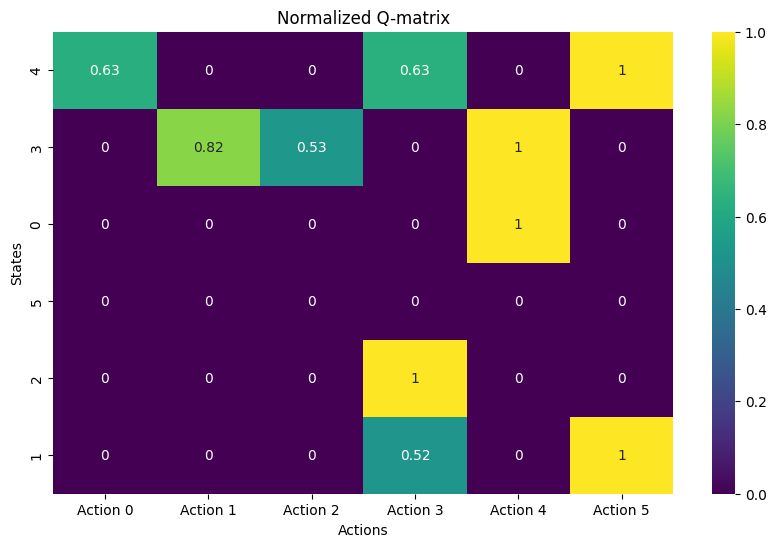

In [8]:
# Author: Till Zemann
# License: MIT License

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

np.random.seed(42)

R = np.array([
    [-1, -1, -1, -1,  0, -1],
    [-1, -1, -1,  0, -1, 100],  # Action from state 1 to state 5
    [-1, -1, -1,  0, -1, -1],
    [-1,  0,  0, -1,  0, -1],
    [0, -1, -1,  0, -1, 100],  # Action from state 4 to state 5
    [-1,  0, -1, -1,  0, 100]  # Goal state, can loop to itself with high reward
])


# Q-Learning agent for the building environment
class BuildingAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.8,
    ):
        # Initialize Q-values for each state-action pair
        self.q_values = defaultdict(lambda: np.zeros(len(R)))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []
        self.episode_rewards = []
        self.episode_lengths = []

    # Select an action using epsilon-greedy policy
    def get_action(self, state: int) -> int:
        if np.random.random() < self.epsilon: # using epsilon to explore in the beginning 
            actions = np.nonzero(R[state] >= 0)[0]  # non zero to avoid penalty
            return np.random.choice(actions)
        else:
            return int(np.argmax(self.q_values[state]))

    # Update Q-values based on the action taken
    def update(self, state: int, action: int, reward: float, next_state: int):
        best_next_action = np.max(self.q_values[next_state])
        td_target = reward + self.discount_factor * best_next_action
        td_error = td_target - self.q_values[state][action]
        self.q_values[state][action] += self.lr * td_error
        self.training_error.append(td_error)

    # Decay epsilon to reduce exploration over time
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

# Parameters for Q-learning
alpha = 0.1  # Learning rate
gamma = 0.8  # Discount factor
n_episodes = 1000
start_epsilon = 1.0
epsilon_decay = 0.99
final_epsilon = 0.1

# Initialize the agent
agent = BuildingAgent(
    learning_rate=alpha,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=gamma
)

# Q-learning algorithm
for episode in tqdm(range(n_episodes)):
    state = np.random.randint(0, len(R))
    total_reward = 0
    length = 0
    while state != 5:  # Goal state is 5
        action = agent.get_action(state)
        next_state = action
        reward = R[state, action]
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        length += 1

    agent.episode_rewards.append(total_reward)
    agent.episode_lengths.append(length)
    agent.decay_epsilon()

# Normalize Q-matrix for better interpretability
Q_normalized = {state: q / np.max(q) if np.max(q) > 0 else q for state, q in agent.q_values.items()}

# Display the normalized Q-matrix in a prettier format
q_df = pd.DataFrame(Q_normalized).T.fillna(0)
q_df.columns = [f"Action {i}" for i in range(len(R))]
print(q_df)

# Heatmap visualization of Q-matrix
plt.figure(figsize=(10, 6))
sns.heatmap(q_df, annot=True, cmap="viridis", cbar=True)
plt.title("Normalized Q-matrix")
plt.xlabel("Actions")
plt.ylabel("States")
plt.show()


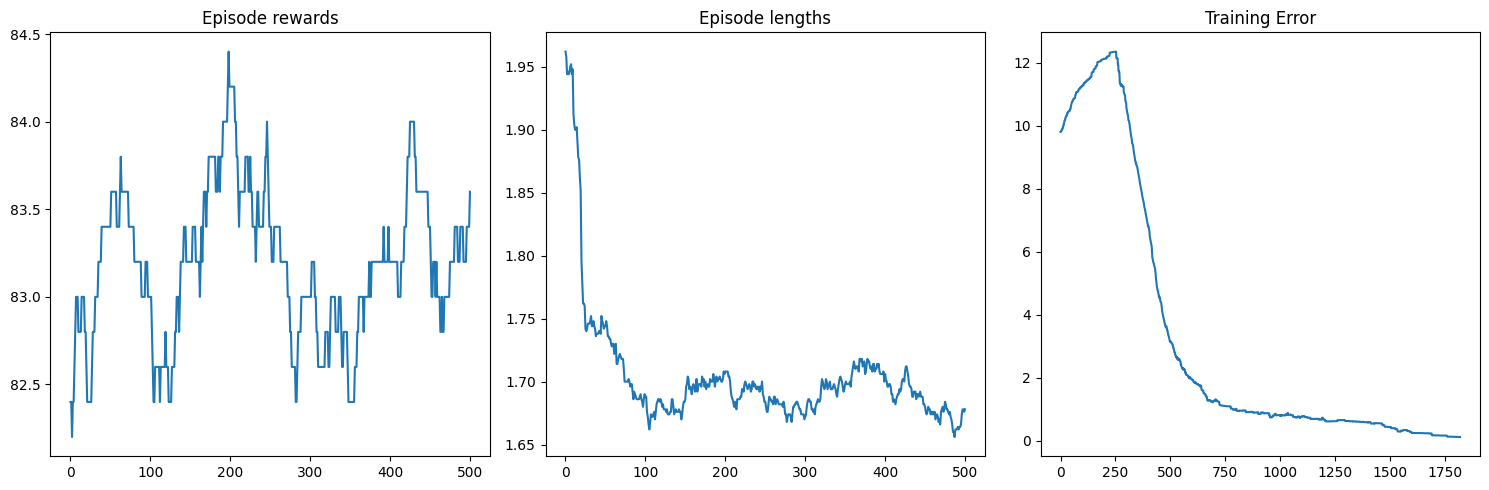

In [10]:

# Visualization of learning process
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(agent.episode_rewards, np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(agent.episode_lengths, np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()



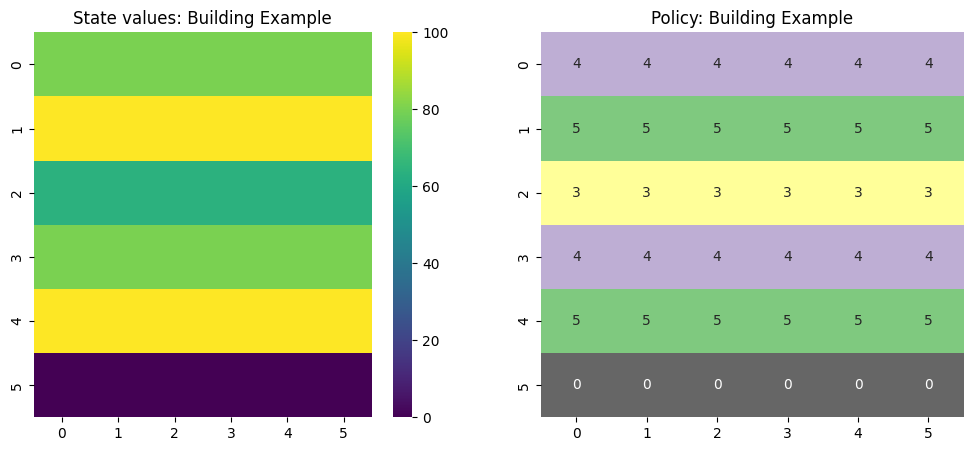

In [11]:

# Function to create value and policy grids
def create_grids(agent):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for state, action_values in agent.q_values.items():
        state_value[state] = float(np.max(action_values))
        policy[state] = int(np.argmax(action_values))

    states = range(len(R))
    actions = range(len(R[0]))

    value_grid = np.zeros((len(states), len(actions)))
    policy_grid = np.zeros((len(states), len(actions)))

    for state in states:
        value_grid[state] = state_value[state]
        policy_grid[state] = policy[state]

    return value_grid, policy_grid

# Function to create plots
def create_plots(value_grid, policy_grid, title: str):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    sns.heatmap(value_grid, ax=axs[0], cmap="viridis")
    axs[0].set_title(f"State values: {title}")
    sns.heatmap(policy_grid, ax=axs[1], cmap="Accent_r", annot=True, cbar=False)
    axs[1].set_title(f"Policy: {title}")

# Create value and policy grids
value_grid, policy_grid = create_grids(agent)

# Plot value and policy grids
create_plots(value_grid, policy_grid, title="Building Example")
plt.show()
